In [1]:
import locale
locale.getpreferredencoding = lambda *args, **kwargs: "UTF-8"
!pip install transformers==4.28.0
!pip install --upgrade accelerate
!pip install jellyfish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import nltk
import csv
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = ''.join([c for c in text if c.isalpha() or c.isspace()]).lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words and perform stemming
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [5]:
# Load the dataset from CSV
df = pd.read_csv('MRP_Dataset_Final_24K.csv')

df['Questions'] = df['Questions'].apply(preprocess_text)
df['Answers'] = df['Answers'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else np.nan)

# Drop rows with missing values
df.dropna(subset=['Answers'], inplace=True)

# Sentiment analysis
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

df['Sentiment'] = df['Questions'].apply(get_sentiment_score)

# Topic modeling - Latent Dirichlet Allocation (LDA)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Questions'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Intent Classification - Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(df['Questions'], df['Answers'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

# Question Similarity - Cosine Similarity
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Questions'])
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Knowledge Base Exploration
frequent_questions = df['Questions'].value_counts().nlargest(5)

# Example usage:
user_input = "What is the minimum age for a driver's license?"
preprocessed_input = preprocess_text(user_input)
sentiment = get_sentiment_score(preprocessed_input)
intent = model.predict(vectorizer.transform([preprocessed_input]))
similar_questions = df['Questions'][similarity_matrix[vectorizer.transform([preprocessed_input]).toarray().argmax()].argsort()[::-1][1:6]]

print("Sentiment Score:", sentiment)
print("Intent:", intent[0])
print("Similar Questions:")
for question in similar_questions:
    print(question)


Sentiment Score: 0.0
Intent: section state person age year permit drive oper street car highway
Similar Questions:
requir charg danger drive
danger drive
tell danger drive
tell danger drive
penalti danger drive


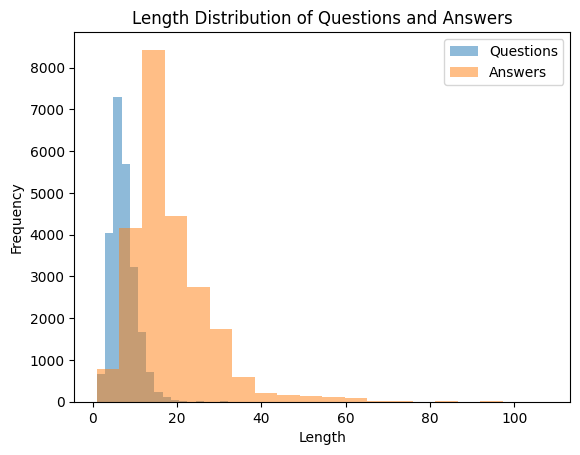

In [6]:
import matplotlib.pyplot as plt

# Calculate the length distribution of questions and answers
question_lengths = df['Questions'].apply(lambda x: len(x.split()))
answer_lengths = df['Answers'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Create histograms to visualize the length distribution of questions and answers
plt.hist(question_lengths, bins=20, alpha=0.5, label='Questions')
plt.hist(answer_lengths, bins=20, alpha=0.5, label='Answers')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Length Distribution of Questions and Answers')
plt.legend()
plt.show()


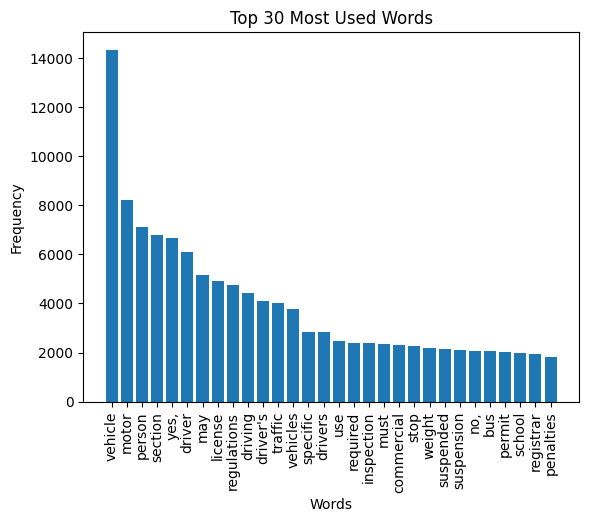

Total number of questions: 23702
Total number of answers: 23702
Total number of words: 623512
Number of words in questions: 169104
Number of words in answers: 454408
Average number of words per question: 7.13
Average number of words per answer: 19.17


In [7]:
import matplotlib.pyplot as plt
from collections import Counter

def count_words(text, stop_words):
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return len(filtered_words)

# Read the CSV file and extract questions and answers
questions = []
answers = []
stop_words = set(stopwords.words('english'))

with open('MRP_Dataset_Final_24K.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    for row in reader:
        questions.append(row[0])
        answers.append(row[1])

# Combine questions and answers into a single list
all_text = questions + answers

# Count total number of questions and answers
total_questions = len(questions)
total_answers = len(answers)

# Count total number of words and words in questions and answers separately
total_words = sum(count_words(text, stop_words) for text in all_text)
question_words = sum(count_words(text, stop_words) for text in questions)
answer_words = sum(count_words(text, stop_words) for text in answers)

# Calculate average number of words per question and answer
avg_words_per_question = question_words / total_questions if total_questions > 0 else 0
avg_words_per_answer = answer_words / total_answers if total_answers > 0 else 0

# Find the top 30 most used words (excluding stopwords)
word_counts = Counter()
for text in all_text:
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    word_counts.update(filtered_words)

top_words = word_counts.most_common(30)

# Plot the distribution of word counts
words, counts = zip(*top_words)
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Used Words')
plt.show()

# Print the results
print("Total number of questions:", total_questions)
print("Total number of answers:", total_answers)
print("Total number of words:", total_words)
print("Number of words in questions:", question_words)
print("Number of words in answers:", answer_words)
print("Average number of words per question:", round(avg_words_per_question, 2))
print("Average number of words per answer:", round(avg_words_per_answer, 2))




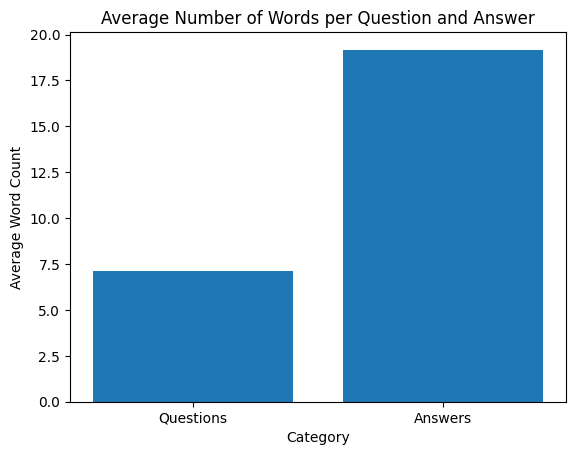

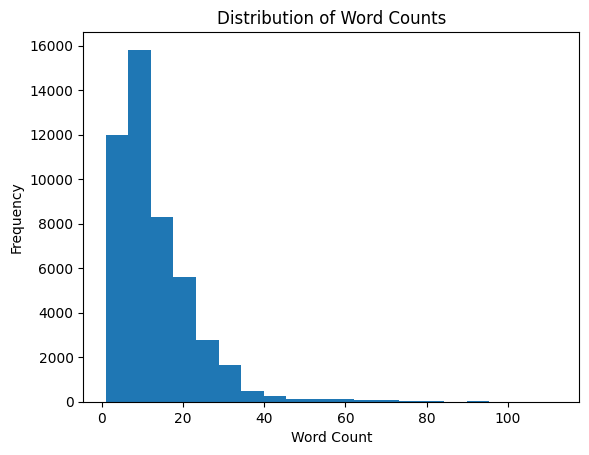

In [8]:
import matplotlib.pyplot as plt
# Bar Chart
categories = ['Questions', 'Answers']
avg_word_counts = [avg_words_per_question, avg_words_per_answer]
plt.bar(categories, avg_word_counts)
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.title('Average Number of Words per Question and Answer')
plt.show()

# Histogram
word_lengths = [count_words(text, stop_words) for text in all_text]
plt.hist(word_lengths, bins=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

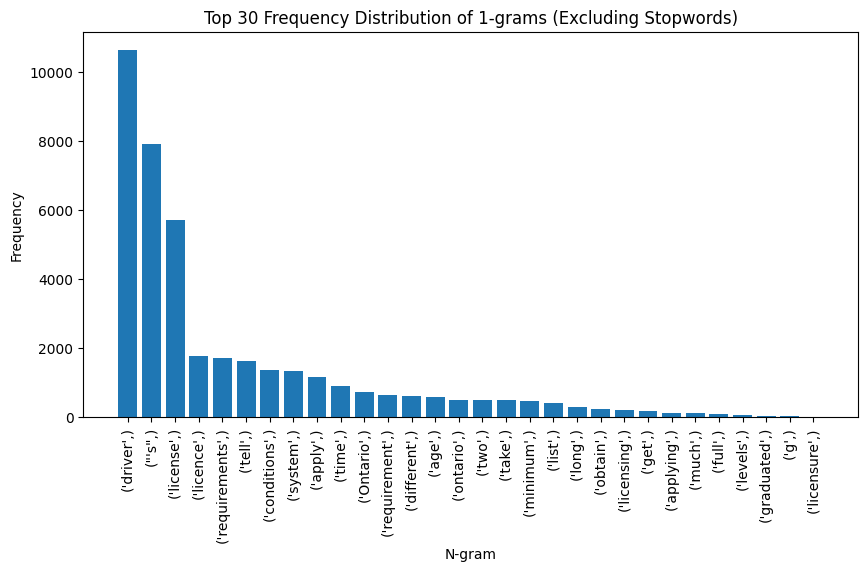

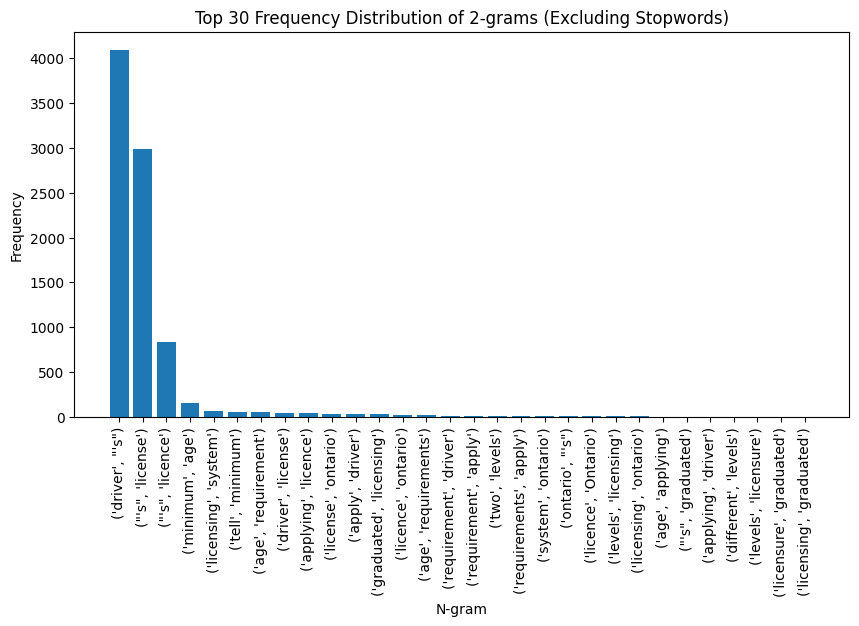

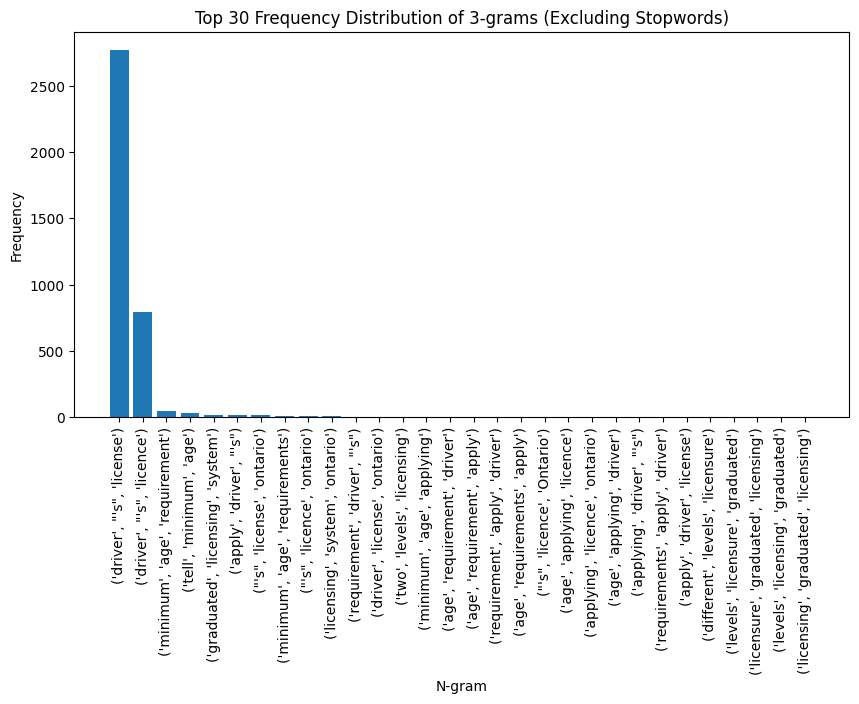

In [9]:
import nltk
from nltk import ngrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Function to generate n-grams from a text, excluding stopwords
def generate_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and '?' not in token]
    ngrams_list = list(ngrams(filtered_tokens, n))
    return ngrams_list

# Function to plot the frequency distribution of n-grams
def plot_ngram_freq(ngram_freq, n):
    sorted_ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    labels, freqs = zip(*sorted_ngram_freq)
    indexes = range(len(labels))

    plt.figure(figsize=(10, 5))
    plt.bar(indexes, freqs)
    plt.xlabel('N-gram')
    plt.ylabel('Frequency')
    plt.title('Top 30 Frequency Distribution of ' + str(n) + '-grams (Excluding Stopwords)')
    plt.xticks(indexes, labels, rotation='vertical')
    plt.show()

# Perform n-gram analysis
all_ngrams = []
for text in all_text:
    for i in range(1, 4):  # Perform analysis for n-grams up to 3 words
        ngrams_list = generate_ngrams(text, i)
        all_ngrams.extend(ngrams_list)

# Calculate frequency distribution of n-grams
ngram_freq_dist = FreqDist(all_ngrams)

# Get the top 30 most common n-grams for each length
top_30_1gram = [(ng, freq) for ng, freq in ngram_freq_dist.items() if len(ng) == 1][:30]
top_30_2gram = [(ng, freq) for ng, freq in ngram_freq_dist.items() if len(ng) == 2][:30]
top_30_3gram = [(ng, freq) for ng, freq in ngram_freq_dist.items() if len(ng) == 3][:30]

# Plot the frequency distribution for each n-gram
plot_ngram_freq(top_30_1gram, 1)
plot_ngram_freq(top_30_2gram, 2)
plot_ngram_freq(top_30_3gram, 3)


In [10]:
import nltk
import csv
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

nltk.download('vader_lexicon')
nltk.download('stopwords')

def calculate_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def count_words(text, stop_words):
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return len(filtered_words)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sentiment Analysis for Questions:
Positive:  2628
Negative:  7692
Neutral:  13382


Sentiment Analysis for Answers:
Positive:  9894
Negative:  9377
Neutral:  4431


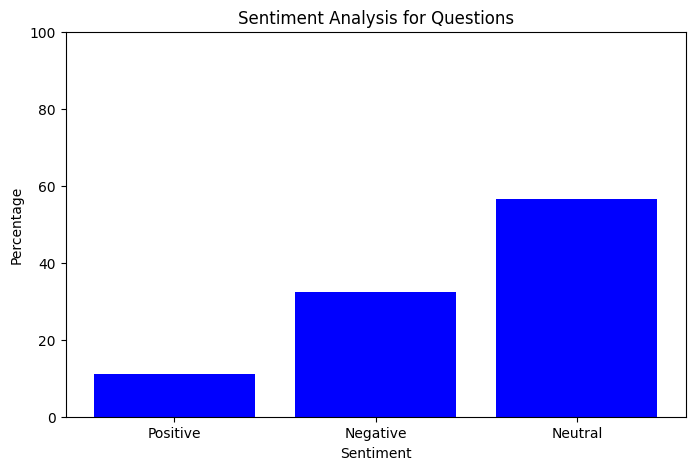

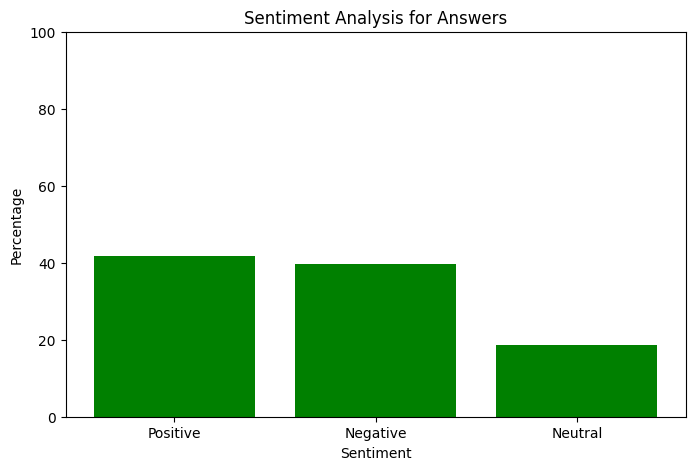

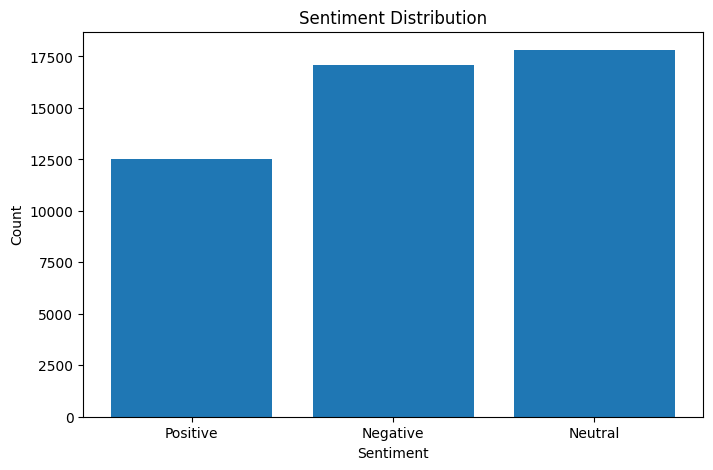

In [11]:
import matplotlib.pyplot as plt

# Perform sentiment analysis on questions and answers
question_sentiments = [calculate_sentiment(question) for question in questions]
answer_sentiments = [calculate_sentiment(answer) for answer in answers]

# Count the number of positive, negative, and neutral sentiments for questions and answers
question_sentiment_counts = {'Positive': 0, 'Negative': 0, 'Neutral': 0}
answer_sentiment_counts = {'Positive': 0, 'Negative': 0, 'Neutral': 0}

for sentiment in question_sentiments:
    question_sentiment_counts[sentiment] += 1

for sentiment in answer_sentiments:
    answer_sentiment_counts[sentiment] += 1

# Print the sentiment analysis results
print("Sentiment Analysis for Questions:")
print("Positive: ", question_sentiment_counts['Positive'])
print("Negative: ", question_sentiment_counts['Negative'])
print("Neutral: ", question_sentiment_counts['Neutral'])
print("\n")
print("Sentiment Analysis for Answers:")
print("Positive: ", answer_sentiment_counts['Positive'])
print("Negative: ", answer_sentiment_counts['Negative'])
print("Neutral: ", answer_sentiment_counts['Neutral'])

# Calculate the percentage of positive, negative, and neutral sentiments for questions and answers
question_sentiment_percentages = {
    'Positive': question_sentiment_counts['Positive'] / len(questions) * 100,
    'Negative': question_sentiment_counts['Negative'] / len(questions) * 100,
    'Neutral': question_sentiment_counts['Neutral'] / len(questions) * 100
}

answer_sentiment_percentages = {
    'Positive': answer_sentiment_counts['Positive'] / len(answers) * 100,
    'Negative': answer_sentiment_counts['Negative'] / len(answers) * 100,
    'Neutral': answer_sentiment_counts['Neutral'] / len(answers) * 100
}

# Create a bar chart to visualize the sentiment analysis results for questions
plt.figure(figsize=(8, 5))
plt.bar(question_sentiment_percentages.keys(), question_sentiment_percentages.values(), color='blue')
plt.title('Sentiment Analysis for Questions')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()

# Create a bar chart to visualize the sentiment analysis results for answers
plt.figure(figsize=(8, 5))
plt.bar(answer_sentiment_percentages.keys(), answer_sentiment_percentages.values(), color='green')
plt.title('Sentiment Analysis for Answers')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()

# Count the number of occurrences for each sentiment category
sentiment_counts = {
    'Positive': answer_sentiment_counts['Positive'] + question_sentiment_counts['Positive'],
    'Negative': answer_sentiment_counts['Negative'] + question_sentiment_counts['Negative'],
    'Neutral': answer_sentiment_counts['Neutral'] + question_sentiment_counts['Neutral']
}

# Create a bar plot to visualize the sentiment distribution
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.keys(), sentiment_counts.values())
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


In [12]:
#ONE TIME USE ONLY CODE TO SPLI THE 24K INTO TWO CSV'S NAMELY TRAIN_DATA AND TEST_DATA


# import csv
# from collections import Counter
# import random

# # Read the CSV file
# data = []
# with open('MRP_Dataset_Final_24K.csv', 'r') as file:
#     reader = csv.DictReader(file)
#     for row in reader:
#         data.append(row)

# # Shuffle the data while preserving the correspondence between questions and answers
# random.shuffle(data)

# # Split the data into two portions (80% and 20%)
# split_index = int(0.8 * len(data))
# train_data = data[:split_index]
# test_data = data[split_index:]

# # Define the column names for the new CSV files
# columns = ['Questions', 'Answers']

# # Write the train data to a new CSV file
# with open('train_data.csv', 'w', newline='') as file:
#     writer = csv.DictWriter(file, fieldnames=columns)
#     writer.writeheader()
#     writer.writerows(train_data)

# # Write the test data to a new CSV file
# with open('test_data.csv', 'w', newline='') as file:
#     writer = csv.DictWriter(file, fieldnames=columns)
#     writer.writeheader()
#     writer.writerows(test_data)

# # Count the number of duplicate answers in the test data
# answer_counts = Counter(row['Answers'] for row in test_data)
# duplicate_count = sum(count > 1 for count in answer_counts.values())

# # Print the count of duplicate answers
# print(f"Count of Duplicate Answers: {duplicate_count}")